<a href="https://colab.research.google.com/github/furlancad/Estudo-PMF/blob/main/(13_e_14)Paired_T_AnovaRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src = "https://github.com/Trading-com-Dados/pmf/blob/main/logotipo-trading-com-dados.svg?raw=true" width = "200">

<center><img src = "https://github.com/Trading-com-Dados/pmf/blob/main/PMF%20002.png?raw=true" width = "700">

---
# **Estatística no Mercado Financeiro**
---

---

### **4.4. Teste T pareado**

Comparação entre médias de 2 grupos mas incluindo um fator de dependência (par a par)

<left><img src = "https://datatab.net/assets/tutorial/paired_t-Test.png" width = "600">

*Weekend effect: o retorno da segunda-feira é frequentemente menor que o da sexta-feira que a precede*


O "Efeito final de semana" ficou muito conhecido no mercado financeiro nas décadas de 80 e 90. Diversos estudos comprovaram que a média dos retornos da segunda feira eram estatisticamente menores que as médias dos retornos das sextas feiras que as antecedia. Apesar de muito ter sido discutido sobre os motivos, não se chegaram a uma conclusão definitiva.

Nosso objetivo será testar se esse efeito ainda pode ser visto nos retornos do IBOV, em 2022, ou seja:

* Hipótese H0 (nula): As médias de retorno <u>não diferem</u> estatisticamente
* Hipótese H1 (alternativa): As médias de retorno  <u>diferem</u> estatisticamente

In [ ]:
!pip install yfinance --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 15.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import pylab
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import yfinance as yf

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
# Obter os dados do IBOV e calcular os retornos diários (%) desde 2010

dados_ibov = yf.download('^BVSP', start='2022-01-01', end='2023-01-01')
dados_ibov['retornos'] = dados_ibov.Close.pct_change()*100
dados_ibov

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,retornos
Date,,,,,,,
2022-01-03,104823.0,106125.0,103413.0,103922.0,103922.0,11128500,NaN
2022-01-04,103922.0,104276.0,103096.0,103514.0,103514.0,11491600,-0.392602
2022-01-05,103514.0,103514.0,100850.0,101006.0,101006.0,0,-2.422861
2022-01-06,101006.0,102235.0,101000.0,101561.0,101561.0,11749200,0.549472
2022-01-07,101561.0,102719.0,101104.0,102719.0,102719.0,11733200,1.140201
...,...,...,...,...,...,...,...
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100,2.218661
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500,-0.875130
2022-12-27,108739.0,109353.0,107418.0,108347.0,108347.0,11158100,-0.359580


In [3]:
# Organizar os dados para obtenção dos dias da semana e da semana do ano

dados_ibov['dia_semana'] = dados_ibov.index.day_name()
dados_ibov['dia_semana_num'] = dados_ibov.index.day_of_week
dados_ibov['semana_ano'] = dados_ibov.index.isocalendar().week
dados_ibov['ano'] = dados_ibov.index.year
dados_ibov['ano_semana'] = dados_ibov['ano'].astype(str) + "_" + dados_ibov['semana_ano'].astype(str)
dados_ibov

,Open,High,Low,Close,Adj Close,Volume,retornos,dia_semana,dia_semana_num,semana_ano,ano,ano_semana
Date,,,,,,,,,,,,
2022-01-03,104823.0,106125.0,103413.0,103922.0,103922.0,11128500,NaN,Monday,0,1,2022,2022_1
2022-01-04,103922.0,104276.0,103096.0,103514.0,103514.0,11491600,-0.392602,Tuesday,1,1,2022,2022_1
2022-01-05,103514.0,103514.0,100850.0,101006.0,101006.0,0,-2.422861,Wednesday,2,1,2022,2022_1
2022-01-06,101006.0,102235.0,101000.0,101561.0,101561.0,11749200,0.549472,Thursday,3,1,2022,2022_1
2022-01-07,101561.0,102719.0,101104.0,102719.0,102719.0,11733200,1.140201,Friday,4,1,2022,2022_1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100,2.218661,Friday,4,51,2022,2022_51
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500,-0.875130,Monday,0,52,2022,2022_52
2022-12-27,108739.0,109353.0,107418.0,108347.0,108347.0,11158100,-0.359580,Tuesday,1,52,2022,2022_52


In [4]:
# Filtrar os dados de interesse para o nosso teste

dados_seg_sex = dados_ibov[(dados_ibov['dia_semana']=='Monday') | (dados_ibov['dia_semana']=='Friday')]
dados_seg_sex.head(10)

,Open,High,Low,Close,Adj Close,Volume,retornos,dia_semana,dia_semana_num,semana_ano,ano,ano_semana
Date,,,,,,,,,,,,
2022-01-03,104823.0,106125.0,103413.0,103922.0,103922.0,11128500,NaN,Monday,0,1,2022,2022_1
2022-01-07,101561.0,102719.0,101104.0,102719.0,102719.0,11733200,1.140201,Friday,4,1,2022,2022_1
2022-01-10,102719.0,102719.0,101038.0,101945.0,101945.0,10264700,-0.753512,Monday,0,2,2022,2022_2
2022-01-14,105530.0,107062.0,105028.0,106928.0,106928.0,11457100,1.324742,Friday,4,2,2022,2022_2
2022-01-17,106927.0,106928.0,106097.0,106692.0,106692.0,6924200,-0.220709,Monday,0,3,2022,2022_3
2022-01-21,109097.0,109786.0,108368.0,108942.0,108942.0,13408400,-0.146652,Friday,4,3,2022,2022_3
2022-01-24,108941.0,108948.0,106624.0,107752.0,107752.0,12700800,-1.092324,Monday,0,4,2022,2022_4
2022-01-28,112611.0,112969.0,111407.0,111478.0,111478.0,13520100,-0.745225,Friday,4,4,2022,2022_4
2022-01-31,111910.0,112495.0,111195.0,112388.0,112388.0,12190800,0.816305,Monday,0,5,2022,2022_5


In [5]:
# Tabela dinâmica com a média e erro padrão da média para segundas e sextas

dados_media = dados_seg_sex[['dia_semana_num','dia_semana','retornos']].groupby(['dia_semana_num','dia_semana']).mean()
dados_media = dados_media.droplevel(0, axis=0)
dados_sem = dados_seg_sex[['dia_semana_num','dia_semana','retornos']].groupby(['dia_semana_num','dia_semana']).sem()
dados_sem = dados_sem.droplevel(0, axis=0)
dados_desde_2010 = pd.concat([dados_media, dados_sem], axis=1)
dados_desde_2010.columns = ['Media_retornos', 'SEM_retornos']
dados_desde_2010

,Media_retornos,SEM_retornos
dia_semana,,
Monday,-0.171282,0.226659
Friday,0.029254,0.203671


In [6]:
# Visualizando os dados da tabela acima

fig = go.Figure()

fig.add_trace(go.Bar(name='Retornos', x=dados_desde_2010.index, y=dados_desde_2010.Media_retornos,
                     error_y=dict(type='data', array=dados_desde_2010.SEM_retornos),
                     marker_color='orange', orientation='v'))

fig.update_layout(title_text='<b>Retornos IBOV</b> (média \xB1 erro padrão da média) por dia da semana <br><b>desde 2010', xaxis_title= '<b>Dia da semana',
                  yaxis_title= '<b>Retorno médio diário (%)', template="none", margin=dict(l=75, r=20, t=75, b=75),
                  paper_bgcolor="#f7f8fa", font=dict(family="Arial", size=13, color="black"), width=600, height=400)

fig.show()

In [7]:
# Formato para T pareado

dados = {'Data':[], 'Monday':[], 'Friday':[], 'Week_monday':[], 'Week_friday':[]}

for i in range(1,len(dados_seg_sex)):
  if (dados_seg_sex.iloc[i-1]['dia_semana']=='Friday') and (dados_seg_sex.iloc[i]['dia_semana']=='Monday'):
    if dados_seg_sex.iloc[i-1]['semana_ano']==(dados_seg_sex.iloc[i]['semana_ano']-1):
      dados['Data'].append(dados_seg_sex.index[i])
      dados['Monday'].append(dados_seg_sex.iloc[i]['retornos'])
      dados['Week_monday'].append(dados_seg_sex.iloc[i]['ano_semana'])
      dados['Friday'].append(dados_seg_sex.iloc[i-1]['retornos'])
      dados['Week_friday'].append(dados_seg_sex.iloc[i-1]['ano_semana'])

df_analise = pd.DataFrame(dados)

In [8]:
df_analise.head(10)

,Data,Monday,Friday,Week_monday,Week_friday
0,2022-01-10,-0.753512,1.140201,2022_2,2022_1
1,2022-01-17,-0.220709,1.324742,2022_3,2022_2
2,2022-01-24,-1.092324,-0.146652,2022_4,2022_3
3,2022-01-31,0.816305,-0.745225,2022_5,2022_4
4,2022-02-07,-0.221836,0.491513,2022_6,2022_5
5,2022-02-14,0.206917,0.187899,2022_7,2022_6
6,2022-02-21,-0.924908,-0.669438,2022_8,2022_7
7,2022-03-07,-2.516729,-0.600872,2022_10,2022_9
8,2022-03-14,-1.597844,-1.715598,2022_11,2022_10
9,2022-03-21,0.731934,1.976547,2022_12,2022_11


In [9]:
# Diferença entre os retornos de sexta e segunda subsequente
# Nesse caso, a distribuição normal da diferença de retornos entre os dois grupos é importante

df_analise['diff_sex_seg'] = df_analise.Friday - df_analise.Monday

In [10]:
# Lembrando que no teste de normalidade, H0 é de que a distribuição é normal

teste_normalidade = stats.normaltest(df_analise['diff_sex_seg'])
print(teste_normalidade)

NormaltestResult(statistic=0.6136865020392478, pvalue=0.7357659224268878)


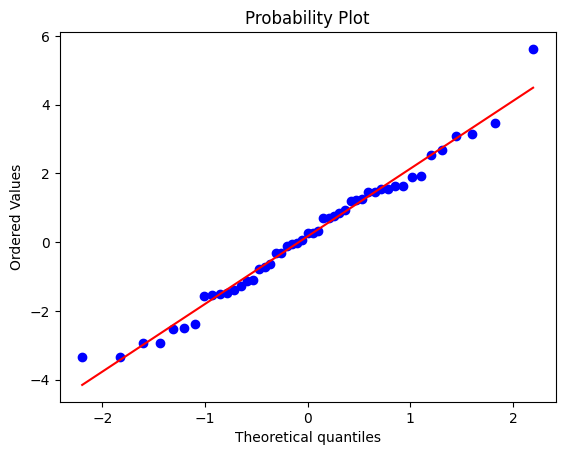

In [11]:
# Relembrando outra forma de observar a normalidade

stats.probplot(df_analise.diff_sex_seg, dist="norm", plot=pylab)
pylab.show()

**Vamos finalmente ao nosso teste estatístico**

*Pergunta: a média dos retornos da segunda-feira é estatisticamente menor que a média dos retornos da sexta-feira que a precede?*

* Hipótese H0 (nula): As médias de retorno <u>não diferem</u> estatisticamente
* Hipótese H1 (alternativa): As médias de retorno  <u>diferem</u> estatisticamente

In [12]:
# Podemos concluir que as médias não diferem, não corroborando a teoria de que existiu um 'weekend effect' para o IBOV no ano de 2022

stats.ttest_rel(df_analise.Monday, df_analise.Friday)

TtestResult(statistic=-0.6062748057855685, pvalue=0.5471889803488991, df=48)

---
### **4.5. ANOVA de Medidas Repetidas**


Você provavelmente já ouviu a expressão "*Sell in May and go away!*", que em uma tradução literal seria algo como "*Venda em maio e vá embora!*". O fato é que além de uma rima legal, essa expressão traz um contexto de sazonalidade de mercado muito interessante e que, sem dúvida, merece nossa atenção.

Aqui o raciocínio será similar ao do teste T pareado, onde os dados apresentam uma dependencia temporal. Desta vez, teremos mais de 2 grupos e por isso usaremos a Anova de medidas repetidas. O aninhamento (dependencia) será entre os meses de um mesmo ano (teremos 12 grupos). Veja que eu não poderia comparar março de 2022 com abril de 2001 por ex.

<center><img src = "https://snbchf.com/wp-content/uploads/2017/05/Sell_in_May.png" width = "500">



**Um pouco mais de curiosidade sobre nosso case:**

Estudos mostram que a expressão original é ainda mais curiosa: "*Sell in May, go away, and come back on St. Leger’s Day*" = Venda em maio, vá embora e volte no dia de 'Saint Leger' (15 de setembro). A estratégia envolve o lucro a partir na sazonalindade anual do mercado. Basicamente, você venderia todas as suas ações em maio, quando o mercado historicamente apresenta um desempenho abaixo do esperado. No mesmo ano, entre outubro e novembro, você os compra novamente, quando o mercado de ações começa a subir novamente.

Nosso objetivo será testar se os retornos mensais do IBOV diferem estatisticamente entre si, buscando detectar o padrão "Sell in May and go away" desde os anos 2000:

* Hipótese H0 (nula): As médias dos retornos mensais <u>são iguais estatisticamente</u> entre os meses do ano
* Hipótese H1 (alternativa): As médias <u>são diferentes</u> estatisticamente

In [ ]:
ibov_ohlc = yf.download('^BVSP', period='max', interval='1d')

ibov_ohlc.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0


In [ ]:
ibov_ohlc = ibov_ohlc.resample('M').agg({"Open": "first", "High": "max", "Low": "min", "Close": "last"})

In [ ]:
ibov_ohlc.head()

,Open,High,Low,Close
Date,,,,
1993-04-30,24.799999,25.400000,23.700001,24.100000
1993-05-31,24.100000,35.599998,23.799999,34.900002
1993-06-30,35.400002,54.799999,35.400002,53.700001
1993-07-31,53.700001,67.400002,51.700001,65.599998
1993-08-31,65.599998,100.099998,60.599998,96.400002


In [ ]:
ibov_ohlc['Resultado_mes'] = (ibov_ohlc['Close'].pct_change()*100).round(2)

In [ ]:
ibov_ohlc.head()

,Open,High,Low,Close,Resultado_mes
Date,,,,,
1993-04-30,24.799999,25.400000,23.700001,24.100000,NaN
1993-05-31,24.100000,35.599998,23.799999,34.900002,44.81
1993-06-30,35.400002,54.799999,35.400002,53.700001,53.87
1993-07-31,53.700001,67.400002,51.700001,65.599998,22.16
1993-08-31,65.599998,100.099998,60.599998,96.400002,46.95


In [ ]:
# Organizar os dados para que eu tenha uma coluna com os retornos mensais, com os meses e os anos da série temporal (23 anos)

ibov_ohlc["Mes"] = ibov_ohlc.index.month_name()
ibov_ohlc["Ano"] = ibov_ohlc.index.year
ibov_ohlc["Mes_num"] = ibov_ohlc.index.strftime('%m')
ibov_ohlc = ibov_ohlc.loc['2000':'2022']
ibov_ohlc

,Open,High,Low,Close,Resultado_mes,Mes,Ano,Mes_num
Date,,,,,,,,
2000-01-31,17098.0,18099.0,15350.0,16388.0,-4.12,January,2000,01
2000-02-29,16389.0,18886.0,16389.0,17660.0,7.76,February,2000,02
2000-03-31,17668.0,19047.0,16922.0,17820.0,0.91,March,2000,03
2000-04-30,17826.0,17826.0,14029.0,15538.0,-12.81,April,2000,04
2000-05-31,15596.0,15944.0,13556.0,14957.0,-3.74,May,2000,05
...,...,...,...,...,...,...,...,...
2022-08-31,103165.0,114375.0,101694.0,109523.0,6.16,August,2022,08
2022-09-30,109524.0,114392.0,106244.0,110037.0,0.47,September,2022,09
2022-10-31,110048.0,120752.0,110048.0,116037.0,5.45,October,2022,10


In [ ]:
# Consigo visualizar as médias mensais dos retornos ao longo dos 23 anos de cobertura
# Colocamos uma formatação condicional para diferenciar meses com médias positivas de negativas

resultado_geral = pd.pivot_table(ibov_ohlc, values="Resultado_mes", index=["Mes_num"], columns=[], aggfunc=np.mean)
resultado_geral = resultado_geral.style.format('{:.3f}', na_rep="").applymap(lambda x: 'background-color : #81b585' if x>0 else 'background-color : #cf7a7a')
resultado_geral

,Resultado_mes
Mes_num,
01,0.808
02,1.170
03,0.190
04,1.507
05,-0.910
06,-0.785
07,1.692
08,1.140
09,-0.815


Agora pra ter uma visão geral dos meses ao longo da série histórica

In [ ]:
# Novamente, usando uma tabela dinâmica, porém com duas categorias de agrupamento (matriz): Ano em linhas e Mês em colunas
# Nesse caso, o parametro usado no argumento aggfunc não importa já que é um valor apenas (poderia ser media, mediana, max...)
# De fato parece q alguns meses como maio são realmente mais "negativos"

resultados_pontuais = pd.pivot_table(ibov_ohlc, values="Resultado_mes", index=["Ano",], columns=["Mes_num"], aggfunc=np.mean)
resultados_pontuais = resultados_pontuais.style.format('{:.3f}', na_rep="").applymap(lambda x: 'background-color : #81b585' if x>0 else 'background-color : #cf7a7a')
resultados_pontuais

Mes_num,01,02,03,04,05,06,07,08,09,10,11,12
Ano,,,,,,,,,,,,
2000,-4.120,7.760,0.910,-12.810,-3.740,11.840,-1.630,5.420,-8.180,-6.660,-10.630,14.840
2001,15.820,-10.080,-9.140,3.320,-1.800,-0.610,-5.540,-6.640,-17.170,6.850,13.790,5.000
2002,-6.310,10.310,-5.540,-1.280,-1.710,-13.390,-12.350,6.340,-16.940,17.920,3.350,7.220
2003,-2.900,-6.030,9.660,11.380,6.890,-3.350,4.620,11.800,5.520,12.310,12.250,10.170
2004,-1.730,-0.440,1.780,-11.450,-0.320,8.210,5.620,2.090,1.940,-0.830,9.010,4.250
2005,-7.040,15.560,-5.430,-6.640,1.460,-0.620,3.960,7.690,12.620,-4.400,5.710,4.820
2006,14.730,0.590,-1.700,6.350,-9.500,0.280,1.220,-2.280,0.600,7.720,6.800,6.060
2007,0.380,-1.680,4.360,6.880,6.770,4.060,-0.380,0.840,10.670,8.030,-3.540,1.400
2008,-6.880,6.720,-3.970,11.320,6.960,-10.430,-8.480,-6.430,-11.030,-24.800,-1.770,2.610


**Normalidade dos dados por grupo**

In [ ]:
# Vamos checar a premissa de normalidade dos dados de cada grupo
# Dessa vez usaremos um groupby um pouco mais complexo, incluindo uma função lambda
# Basicamente agrupar os dados de retornos por mes e aplicar a função do teste de normalidade, retornando apenas o p valor

pvalor_normalidade = ibov_ohlc[['Mes_num','Resultado_mes']].groupby('Mes_num').agg(lambda x: stats.normaltest(x).pvalue)
pvalor_normalidade

,Resultado_mes
Mes_num,
01,0.137649
02,0.685920
03,0.000082
04,0.754882
05,0.640768
06,0.901192
07,0.534325
08,0.512283
09,0.494974


Veja que março e outubro foram os únicos meses sem apresentar normalidade dos dados.

Basicamente devido a duas grandes crises: março devido ao resultado de 2020 Covid (-29.90) e outubro 2008 crise subprimes (-24.80)

In [ ]:
# Filtrar os dados de março e ver se retirando o dado de 2020 (Covid) os dados apresentam distribuição normal

mar = ibov_ohlc[ibov_ohlc.Mes=='March']
stats.normaltest(mar[mar.Ano!=2020]['Resultado_mes'])

NormaltestResult(statistic=2.720223565943761, pvalue=0.2566320882526268)

In [ ]:
# Filtrar os dados de outubro e ver se retirando o dado de 2008 (Subprimes) os dados apresentam distribuição normal

out = ibov_ohlc[ibov_ohlc.Mes=='October']
stats.normaltest(out[out.Ano!=2008]['Resultado_mes'])

NormaltestResult(statistic=0.5791453964548765, pvalue=0.7485833702485929)

OBS: Como temos 23 repetições, vamos optar por filtrar esses dois anos onde tivemos as duas maiores crises econômicas desse século. Uma solução seria transformar os dados ou usar um teste não paramétrico (de mediana e não de média).

Mas deixaremos esses passos para um outro momento.

In [ ]:
# Outra forma de filtro, dessa vez retirando os anos de 2008 e 2020 para todos os meses

ibov_ohlc_sem_crises = ibov_ohlc[~ibov_ohlc.Ano.isin([2008,2020])]
ibov_ohlc_sem_crises

,Open,High,Low,Close,Resultado_mes,Mes,Ano,Mes_num
Date,,,,,,,,
2000-01-31,17098.0,18099.0,15350.0,16388.0,-4.12,January,2000,01
2000-02-29,16389.0,18886.0,16389.0,17660.0,7.76,February,2000,02
2000-03-31,17668.0,19047.0,16922.0,17820.0,0.91,March,2000,03
2000-04-30,17826.0,17826.0,14029.0,15538.0,-12.81,April,2000,04
2000-05-31,15596.0,15944.0,13556.0,14957.0,-3.74,May,2000,05
...,...,...,...,...,...,...,...,...
2022-08-31,103165.0,114375.0,101694.0,109523.0,6.16,August,2022,08
2022-09-30,109524.0,114392.0,106244.0,110037.0,0.47,September,2022,09
2022-10-31,110048.0,120752.0,110048.0,116037.0,5.45,October,2022,10


In [ ]:
# Vemos que agora todos os dados estão normais

pvalor_normalidade = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby('Mes_num').agg(lambda x: stats.normaltest(x).pvalue)
pvalor_normalidade

,Resultado_mes
Mes_num,
01,0.111705
02,0.446556
03,0.313153
04,0.979249
05,0.759374
06,0.776575
07,0.459188
08,0.741196
09,0.364258


**Teste de Levene (homocedasticidade)**

In [ ]:
# Aplicando os filtros no dataframe (query) para Teste de Levene (homocedasticidade)

jan = ibov_ohlc_sem_crises.query("Mes in 'January'")['Resultado_mes']
fev = ibov_ohlc_sem_crises.query("Mes in 'February'")['Resultado_mes']
mar = ibov_ohlc_sem_crises.query("Mes in 'March'")['Resultado_mes']
abr = ibov_ohlc_sem_crises.query("Mes in 'April'")['Resultado_mes']
mai = ibov_ohlc_sem_crises.query("Mes in 'May'")['Resultado_mes']
jun = ibov_ohlc_sem_crises.query("Mes in 'June'")['Resultado_mes']
jul = ibov_ohlc_sem_crises.query("Mes in 'July'")['Resultado_mes']
ago = ibov_ohlc_sem_crises.query("Mes in 'August'")['Resultado_mes']
setem = ibov_ohlc_sem_crises.query("Mes in 'September'")['Resultado_mes'] # set já é uma palavra reservada no python
out = ibov_ohlc_sem_crises.query("Mes in 'October'")['Resultado_mes']
nov = ibov_ohlc_sem_crises.query("Mes in 'November'")['Resultado_mes']
dez = ibov_ohlc_sem_crises.query("Mes in 'December'")['Resultado_mes']

In [ ]:
# Assim como no teste de normalidade, H0 é de que as variâncias são homogenêas

stats.levene(jan, fev, mar, abr, mai, jun, jul, ago, setem, out, nov, dez)

LeveneResult(statistic=0.6898841360552501, pvalue=0.7477267667720083)

**Chegamos ao código da ANOVA de medidas repetidas**



Precisaremos de uma outra biblioteca para executar a Anova de medidas repetidas e depois o teste post hoc pairwise

In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pingouin as pg
from pingouin import mixed_anova, read_dataset

Retomando...  *Nosso objetivo será testar se os retornos mensais do IBOV diferem estatisticamente entre si, buscando detectar o padrão "Sell in May and go away" desde os anos 2000:*

* Hipótese H0 (nula): As médias dos retornos mensais são iguais estatisticamente entre os meses do ano
* Hipótese H1 (alternativa): As médias são diferentes estatisticamente

In [ ]:
# dv será nossa variável resposta, no caso, retornos mensais
# subject indica o fator de dependencia, nosso caso o Ano
# within indica nossos grupos a serem comparados (passado como lista, se dois itens teríamos uma "two way anova de medidas repetidas")

anova_medidas_rep = pg.rm_anova(data=ibov_ohlc_sem_crises, dv='Resultado_mes', within='Mes', subject='Ano', detailed=True)
anova_medidas_rep

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Mes,528.274852,11,48.024987,1.142335,0.329546,0.048631,0.623794
1,Error,9249.039556,220,42.041089,NaN,NaN,NaN,NaN


Observe o p valor (p-unc) = 0.329

**Não rejeitamos H0, as médias dos retornos entre os meses não diferem significativamente**

Se observarmos, o MS (do ingles mean square, ou quadrado médio) é próximo entre os grupos (Mes) e entre o Erro (dentro dos grupos).

Ele representa a variância distribuida entre grupos x dentro dos grupos.

A ANOVA em geral se baseará nessa diferença (cálculo do F e consequentemente do p).

Quando minha variação entre grupos foi bem maior que dentro dos grupos, teremos um resultado significativo.

Veja que essa variação é realmente muito alta dentro dos meses

In [ ]:
# Tabela dinâmica com a média e erro padrão da média para jogar na figura

dados_media = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby(['Mes_num']).mean()
dados_sem = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby(['Mes_num']).std()
dados_figura = pd.concat([dados_media, dados_sem], axis=1)
dados_figura.columns = ['Media_retornos', 'SEM_retornos']

fig = go.Figure()

fig.add_trace(go.Bar(name='Retornos', x=dados_figura.index, y=dados_figura.Media_retornos,
                     error_y=dict(type='data', array=dados_figura.SEM_retornos),
                     marker_color='orange', orientation='v'))

fig.update_layout(title_text='<b>Retornos mensais do IBOV</b> (média \xB1 desvio padrão) <br><b>desde 2000', xaxis_title= '<b>Mês',
                  yaxis_title= '<b>Retorno médio mensal (%)', template="none", margin=dict(l=75, r=20, t=75, b=75),
                  paper_bgcolor="#f7f8fa", font=dict(family="Arial", size=13, color="black"), width=800, height=400)

fig.show()

---
**Mas aqui um ponto muito importante, que acaba sendo uma limitação dos testes
de grupos como ANOVA**

E esse é um detalhe interessante, que mostra que dados reais muitas vezes são mais complexos que os exemplos "bonitinhos" dos livros

**Observe o seguinte: rodaremos o teste post-hoc mesmo não tendo ANOVA significativa**

In [ ]:
df_post_hoc = pg.pairwise_ttests(data=ibov_ohlc_sem_crises, dv='Resultado_mes', within='Mes', subject='Ano')
df_post_hoc

/usr/local/lib/python3.9/dist-packages/pingouin/pairwise.py:28: UserWarning:

pairwise_ttests is deprecated, use pairwise_tests instead.



,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Mes,April,August,True,True,-0.507392,20.0,two-sided,0.617430,0.256,-0.164146
1,Mes,April,December,True,True,-1.000854,20.0,two-sided,0.328854,0.355,-0.333312
2,Mes,April,February,True,True,-0.307803,20.0,two-sided,0.761415,0.237,-0.106481
3,Mes,April,January,True,True,-0.300269,20.0,two-sided,0.767071,0.237,-0.086911
4,Mes,April,July,True,True,-0.608646,20.0,two-sided,0.549610,0.269,-0.180538
...,...,...,...,...,...,...,...,...,...,...,...
61,Mes,May,October,True,True,-2.604393,20.0,two-sided,0.016965,3.257,-0.828754
62,Mes,May,September,True,True,-0.745469,20.0,two-sided,0.464660,0.292,-0.209492
63,Mes,November,October,True,True,-1.466044,20.0,two-sided,0.158183,0.576,-0.391340
64,Mes,November,September,True,True,0.594666,20.0,two-sided,0.558735,0.267,0.181359


Como temos muitas linhas, vamos filtrar caso haja alguma com p <0.05

In [ ]:
df_post_hoc[df_post_hoc['p-unc']<0.05]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
17,Mes,August,May,True,True,2.306572,20.0,two-sided,0.031910,1.95,0.568420
24,Mes,December,June,True,True,2.268368,20.0,two-sided,0.034533,1.83,0.607677
26,Mes,December,May,True,True,2.643939,20.0,two-sided,0.015570,3.496,0.758407
56,Mes,March,May,True,True,2.102906,20.0,two-sided,0.048336,1.402,0.562934
61,Mes,May,October,True,True,-2.604393,20.0,two-sided,0.016965,3.257,-0.828754


E surpreendentemente vemos que mesmo com p valor da ANOVA > 0.05, quando rodamos os testes par a par (pairwise) encontramos alguns pares significativos.

Observe que isso ocorre principalmente com o mes de Maio vs outro meses mais positivos. Embora raras, essas divergencias entre testes acabam acontecendo, principalmente quando você tem muitos grupos (no nosso caso 12)

Vamos rodar outra Anova, dessa vez com apenas 4 meses (4 grupos)

In [ ]:
from statsmodels.stats.anova import AnovaRM

# depvar será nossa variável resposta, no caso, retornos mensais
# subject indica o fator de dependencia, nosso caso o Ano
# within indica nossos grupos a serem comparados (passado colo lista, se dois itens teríamos uma "two way anova de medidas repetidas")

df_ANOVA = pg.rm_anova(data=ibov_ohlc_sem_crises.query("Mes in ['March', 'May', 'October', 'December']"), dv='Resultado_mes', within='Mes', subject='Ano', detailed=True)
df_ANOVA

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Mes,366.996613,3,122.332204,3.21625,0.029022,0.109497,0.924634
1,Error,2282.139562,60,38.035659,NaN,NaN,NaN,NaN


Temos um resultado que mostra que as médias dos retornos são diferentes entre os 4 meses

**Com essa aula, encerramos os testes de comparação de médias.**

**Agora é com vocês, exercitem os testes com cases reais do mercado e compartilhem conosco!!**